# Plot Neural Manifolds

# Setup

In [1]:
import os
import subprocess
import sys
import warnings

warnings.filterwarnings("ignore")

gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(os.path.join(gitroot_path[:-1], "neurometry"))
print("Working directory: ", os.getcwd())

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)
sys.path.append(os.getcwd())
print("Directory added to path: ", os.getcwd())

Working directory:  /Users/facosta/Desktop/code/neurometry/neurometry
Directory added to path:  /Users/facosta/Desktop/code/neurometry
Directory added to path:  /Users/facosta/Desktop/code/neurometry/neurometry


# Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import json

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

import default_config as config
import neurometry.datasets.utils as utils
import neurometry.models.neural_vae as neural_vae
import train
import viz

FileNotFoundError: [Errno 2] No such file or directory: 'api_key.txt'

# Synthetic Experiment Showing petals on 3 neurons

In [5]:
# Create arrays of zeros with length 360
n0 = np.zeros(360)
n1 = np.zeros(360)
n2 = np.zeros(360)

# Define the peak positions and bump width
peak_pos = [150, 270, 30]
bump_width = 60

# Create the smooth bumps at the specified peak positions
for i in range(len(peak_pos)):
    peak = peak_pos[i]
    left = peak - bump_width // 2
    right = peak + bump_width // 2
    x = np.linspace(-1, 1, bump_width)
    bump = np.exp(-(x**2) * 0.1)  # Gaussian bump
    bump /= np.max(bump)  # Normalize to maximum amplitude of 1
    if right >= 360:
        n_arr = np.concatenate((n0[left:], n0[: right - 360]))
    else:
        n_arr = n0[left:right]
    n_arr += bump

    # Assign the bump to the appropriate array
    if i == 0:
        n0[left:right] = n_arr
    elif i == 1:
        n1[left:right] = n_arr
    elif i == 2:
        n2[left:right] = n_arr

In [4]:
def create_bumps_array(positions, widths, num_angles):
    n_cells = len(positions)

    angles = np.linspace(0, 360, num_angles)
    place_fields = np.zeros((n_cells, num_angles))

    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(121)
    ax1.set_xlabel("Lab angles")
    ax1.set_ylabel("Activation")

    for cell_id in range(n_cells):
        peak_pos = positions[cell_id]
        bump_std = widths[cell_id]
        bump = np.exp(-((angles - 180) ** 2) / (2 * bump_std**2))  # Gaussian bump
        bump /= np.max(bump)
        place_field = np.zeros(num_angles)
        place_field += bump
        place_field = np.roll(place_field, int((peak_pos - 180) * (num_angles / 360)))
        place_fields[cell_id, :] = place_field

        ax1.plot(angles, place_field, c=f"C{cell_id}", label=f"Neuron {cell_id}")

    ax1.legend()

    ax2 = fig.add_subplot(122)
    ax2.set_xlabel("Lab angles")
    ax2.set_ylabel("Neuron #")
    im = ax2.imshow(
        place_fields,
        cmap="viridis",
        aspect="auto",
        interpolation="none",
        extent=(0, 360, 2, 0),
    )
    plt.colorbar(im, label="Activation")

    return place_fields, fig

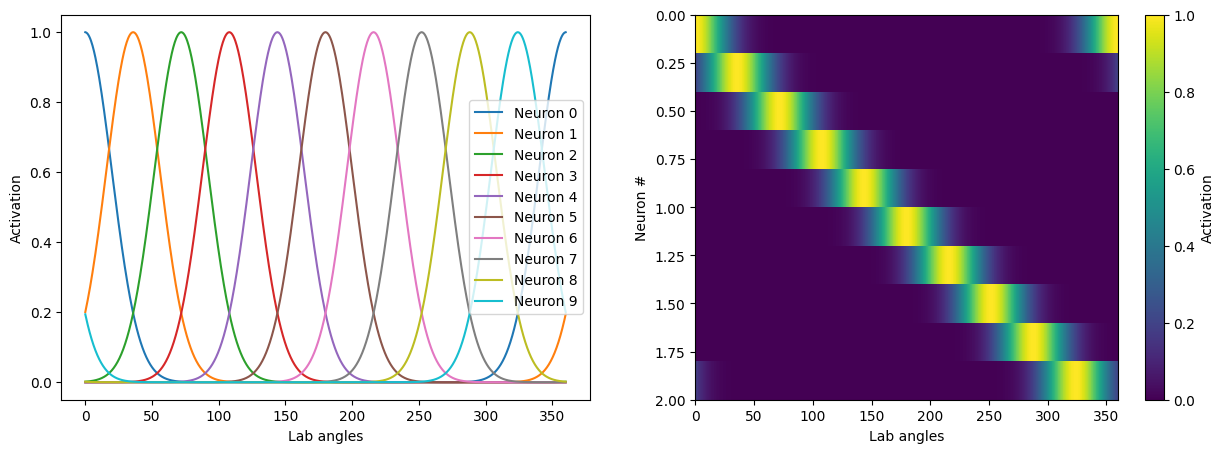

In [9]:
positions = np.arange(0, 360, 36)
widths = 20 * np.ones_like(positions)

place_fields, fig = create_bumps_array(positions, widths, 1000)
# fig.savefig("notebooks/figures/synthetic_activations.svg")

In [131]:
n0, n1, n2 = place_fields

df = pd.DataFrame({"angles": np.linspace(0, 360, 1000), "n0": n0, "n1": n1, "n2": n2})
df

,angles,n0,n1,n2
0,0.000000,0.322476,0.000876,2.808852e-32
1,0.360360,0.331284,0.000906,1.818017e-32
2,0.720721,0.340221,0.000938,1.175176e-32
3,1.081081,0.349287,0.000970,7.586544e-33
4,1.441441,0.358477,0.001003,4.891264e-33
...,...,...,...,...
995,358.558559,0.280460,0.000739,2.425069e-31
996,358.918919,0.288588,0.000765,1.579839e-31
997,359.279279,0.296855,0.000792,1.027869e-31
998,359.639640,0.305260,0.000819,6.678806e-32


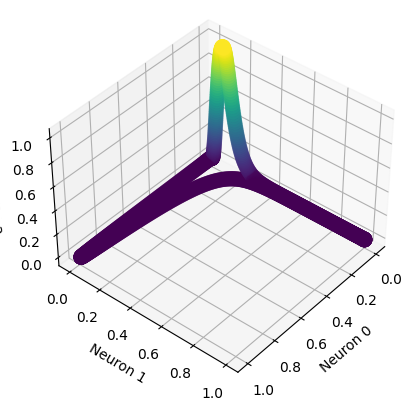

In [137]:
%matplotlib inline
# import plotly.express as px

# fig = px.line_3d(df, x="n0", y="n1", z="n2")
# fig.show()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

ax.scatter(n0, n1, n2, c=n2, cmap="viridis", s=100)
ax.set_xlabel("Neuron 0")
ax.set_ylabel("Neuron 1")
ax.set_zlabel("Neuron 2")
ax.view_init(elev=40.0, azim=40)
# fig.savefig("notebooks/figures/synthetic_place_cells_n2.svg")
# #ax.plot(dataset_3neurons[:, 0], dataset_3neurons[:, 1], dataset_3neurons[:, 2])

# Synthetic Experiment Showing petals on 3 neurons

In [5]:
# Create arrays of zeros with length 360
n0 = np.zeros(360)
n1 = np.zeros(360)
n2 = np.zeros(360)

# Define the peak positions and bump width
peak_pos = [150, 270, 30]
bump_width = 60

# Create the smooth bumps at the specified peak positions
for i in range(len(peak_pos)):
    peak = peak_pos[i]
    left = peak - bump_width // 2
    right = peak + bump_width // 2
    x = np.linspace(-1, 1, bump_width)
    bump = np.exp(-(x**2) * 0.1)  # Gaussian bump
    bump /= np.max(bump)  # Normalize to maximum amplitude of 1
    if right >= 360:
        n_arr = np.concatenate((n0[left:], n0[: right - 360]))
    else:
        n_arr = n0[left:right]
    n_arr += bump

    # Assign the bump to the appropriate array
    if i == 0:
        n0[left:right] = n_arr
    elif i == 1:
        n1[left:right] = n_arr
    elif i == 2:
        n2[left:right] = n_arr

In [6]:
def create_bumps_array(positions, widths, num_angles):
    n_cells = len(positions)

    angles = np.linspace(0, 360, num_angles)
    place_fields = np.zeros((n_cells, num_angles))

    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(121)
    ax1.set_xlabel("Lab angles")
    ax1.set_ylabel("Activation")

    for cell_id in range(n_cells):
        peak_pos = positions[cell_id]
        bump_std = widths[cell_id]
        bump = np.exp(-((angles - 180) ** 2) / (2 * bump_std**2))  # Gaussian bump
        bump /= np.max(bump)
        place_field = np.zeros(num_angles)
        place_field += bump
        place_field = np.roll(place_field, int((peak_pos - 180) * (num_angles / 360)))
        place_fields[cell_id, :] = place_field

        ax1.plot(angles, place_field, c=f"C{cell_id}", label=f"Neuron {cell_id}")

    ax1.legend()

    ax2 = fig.add_subplot(122)
    ax2.set_xlabel("Lab angles")
    ax2.set_ylabel("Neuron #")
    im = ax2.imshow(
        place_fields,
        cmap="viridis",
        aspect="auto",
        interpolation="none",
        extent=(0, 360, 2, 0),
    )
    plt.colorbar(im, label="Activation")

    return place_fields, fig

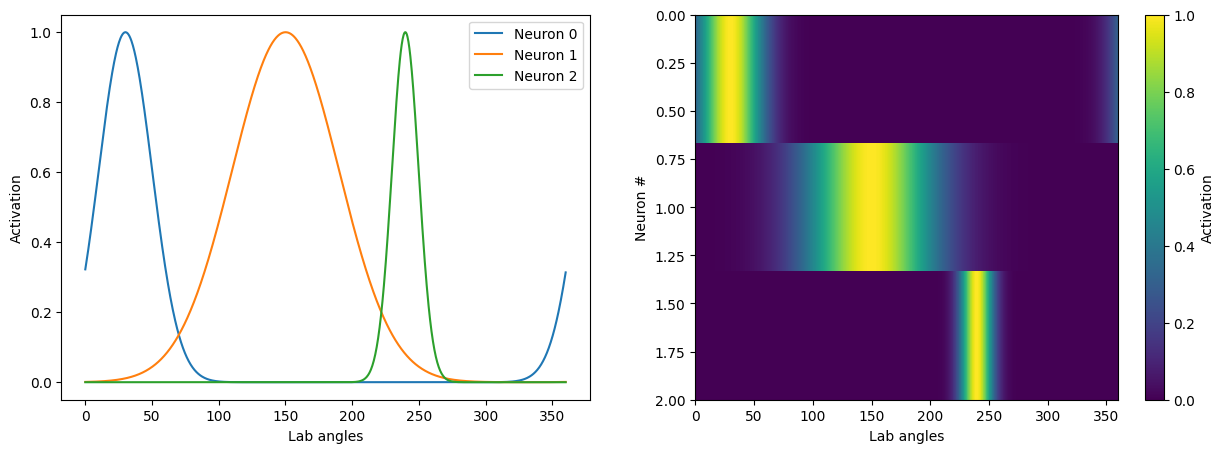

In [7]:
place_fields, fig = create_bumps_array([30, 150, 240], [20, 40, 10], 1000)
# fig.savefig("notebooks/figures/synthetic_activations.svg")

In [131]:
n0, n1, n2 = place_fields

df = pd.DataFrame({"angles": np.linspace(0, 360, 1000), "n0": n0, "n1": n1, "n2": n2})
df

,angles,n0,n1,n2
0,0.000000,0.322476,0.000876,2.808852e-32
1,0.360360,0.331284,0.000906,1.818017e-32
2,0.720721,0.340221,0.000938,1.175176e-32
3,1.081081,0.349287,0.000970,7.586544e-33
4,1.441441,0.358477,0.001003,4.891264e-33
...,...,...,...,...
995,358.558559,0.280460,0.000739,2.425069e-31
996,358.918919,0.288588,0.000765,1.579839e-31
997,359.279279,0.296855,0.000792,1.027869e-31
998,359.639640,0.305260,0.000819,6.678806e-32


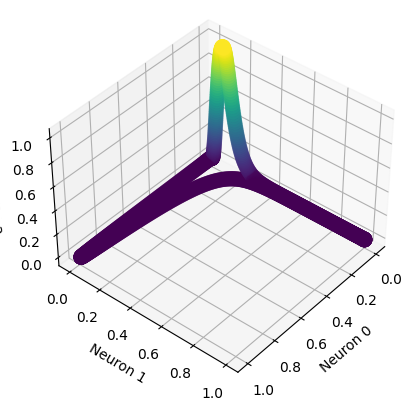

In [137]:
%matplotlib inline
# import plotly.express as px

# fig = px.line_3d(df, x="n0", y="n1", z="n2")
# fig.show()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

ax.scatter(n0, n1, n2, c=n2, cmap="viridis", s=100)
ax.set_xlabel("Neuron 0")
ax.set_ylabel("Neuron 1")
ax.set_zlabel("Neuron 2")
ax.view_init(elev=40.0, azim=40)
# fig.savefig("notebooks/figures/synthetic_place_cells_n2.svg")
# #ax.plot(dataset_3neurons[:, 0], dataset_3neurons[:, 1], dataset_3neurons[:, 2])

# Get config for the run of interest

In [8]:
run_id = "3b87058c"
expt = "34"

CONFIG_DIR = os.path.join(os.getcwd(), "results", "configs")

print(f"Config in directory: {CONFIG_DIR}:")
for config_file in os.listdir(CONFIG_DIR):
    if run_id in config_file:
        print(config_file)
        run_id_config_file = config_file

Config in directory: /home/facosta/neurometry/neurometry/results/configs:
run_3b87058c_experimental_34_gain_1.json


Use this for expt 34, whose config was not recorded:

In [7]:
# config_dict = {
#     "batch_size": 4,
#     "decoder_depth": 10,
#     "decoder_width": 200,
#     "encoder_depth": 5,
#     "encoder_width": 50,
#     "lr": 0.0002751022718020967,
#     "dataset_name": "experimental",
#     "sweep_name": "experimental_34_gain_1",
#     "expt_id": "34",
#     "timestep_microsec": 100000,
#     "smooth": True,
#     "select_gain_1": True,
#     "n_times": None,
#     "embedding_dim": None,
#     "distortion_amp": None,
#     "noise_var": None,
#     "manifold_dim": 1,
#     "latent_dim": 2,
#     "posterior_type": "hyperspherical",
#     "distortion_func": None,
#     "n_wiggles": None,
#     "radius": None,
#     "major_radius": None,
#     "minor_radius": None,
#     "synthetic_rotation": None,
#     "device": "cuda",
#     "log_interval": 20,
#     "checkpt_interval": 20,
#     "scheduler": False,
#     "n_epochs": 150,
#     "alpha": 1.0,
#     "beta": 0.03,
#     "gamma": 30,
#     "sftbeta": 4.5,
#     "gen_likelihood_type": "gaussian",
#     "gain": 1,
#     "run_name": "run_87d52ebd_experimental_34_gain_1",
#     "results_prefix": "run_87d52ebd_experimental_34_gain_1",
#     "data_n_times": 8327,
#     "data_dim": 40,
# }

Use this if a config file is present:

In [9]:
with open(
    os.path.join(CONFIG_DIR, run_id_config_file),
    "r",
) as f:
    config_dict = json.load(f)

config_dict

{'lr': 3.3826282855919744e-06,
 'batch_size': 16,
 'encoder_width': 400,
 'encoder_depth': 8,
 'decoder_width': 400,
 'decoder_depth': 8,
 'drop_out_p': 0,
 'dataset_name': 'experimental',
 'sweep_name': 'experimental_34_gain_1',
 'expt_id': '34',
 'timestep_microsec': 1000000,
 'smooth': True,
 'select_gain_1': True,
 'n_times': None,
 'embedding_dim': None,
 'geodesic_distortion_amp': None,
 'noise_var': None,
 'grid_scale': None,
 'arena_dims': None,
 'n_cells': None,
 'grid_orientation_mean': None,
 'grid_orientation_std': None,
 'field_width': None,
 'resolution': None,
 'manifold_dim': 1,
 'latent_dim': 2,
 'posterior_type': 'hyperspherical',
 'geodesic_distortion_func': None,
 'n_wiggles': None,
 'radius': None,
 'major_radius': None,
 'minor_radius': None,
 'synthetic_rotation': None,
 'device': 'cuda',
 'log_interval': 20,
 'checkpt_interval': 20,
 'batch_shuffle': True,
 'scheduler': False,
 'n_epochs': 250,
 'alpha': 1.0,
 'beta': 0.001,
 'gamma': 20,
 'gamma_moving': 10,
 '

In [10]:
# HACK-ALERT: we need to manually add elements to the config
# These are new parameters that have been added to default_config since this run.

if "batch_shuffle" not in config_dict:
    config_dict["batch_shuffle"] = True
if "n_grid_points" not in config_dict:
    config_dict["n_grid_points"] = 100
if "gamma_moving" not in config_dict:
    config_dict["gamma_moving"] = 0
if "gamma_dynamic" not in config_dict:
    config_dict["gamma_dynamic"] = 0
if "drop_out_p" not in config_dict:
    config_dict["drop_out_p"] = 0


# Convert a dict into an object where attributes are accessed with "."
# This is needed for the utils.load() function
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self


config = AttrDict(config_dict)
config

{'lr': 3.3826282855919744e-06,
 'batch_size': 16,
 'encoder_width': 400,
 'encoder_depth': 8,
 'decoder_width': 400,
 'decoder_depth': 8,
 'drop_out_p': 0,
 'dataset_name': 'experimental',
 'sweep_name': 'experimental_34_gain_1',
 'expt_id': '34',
 'timestep_microsec': 1000000,
 'smooth': True,
 'select_gain_1': True,
 'n_times': None,
 'embedding_dim': None,
 'geodesic_distortion_amp': None,
 'noise_var': None,
 'grid_scale': None,
 'arena_dims': None,
 'n_cells': None,
 'grid_orientation_mean': None,
 'grid_orientation_std': None,
 'field_width': None,
 'resolution': None,
 'manifold_dim': 1,
 'latent_dim': 2,
 'posterior_type': 'hyperspherical',
 'geodesic_distortion_func': None,
 'n_wiggles': None,
 'radius': None,
 'major_radius': None,
 'minor_radius': None,
 'synthetic_rotation': None,
 'device': 'cuda',
 'log_interval': 20,
 'checkpt_interval': 20,
 'batch_shuffle': True,
 'scheduler': False,
 'n_epochs': 250,
 'alpha': 1.0,
 'beta': 0.001,
 'gamma': 20,
 'gamma_moving': 10,
 '

# Get data and curvature profile

### Inspect data (recordings) for outliers

In [11]:
dataset_torch, labels, train_loader, test_loader = utils.load(config)
dataset_torch = dataset_torch.to(config.device)
_, data_dim = dataset_torch.shape

INFO:root:# - Found file at /home/facosta/neurometry/neurometry/data/binned/expt34_times_timestep1000000.txt! Loading...
INFO:root:# - Found file at /home/facosta/neurometry/neurometry/data/binned/expt34_place_cells_timestep1000000.npy! Loading...
INFO:root:# - Found file at /home/facosta/neurometry/neurometry/data/binned/expt34_labels_timestep1000000.txt! Loading...


The dataset contains only one gain value: 1.0
Dataset shape: (934, 40).


We plot the histogram of the values in the original dataset, to see if there are outliers.

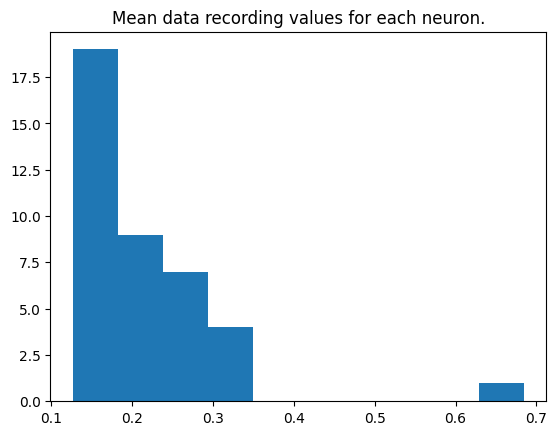

In [169]:
plt.hist(dataset_torch.mean(axis=0).cpu().numpy())
plt.title("Mean data recording values for each neuron.");

### Inspect curvature norms for outliers and filter

We filter the data to remove very high curvatures

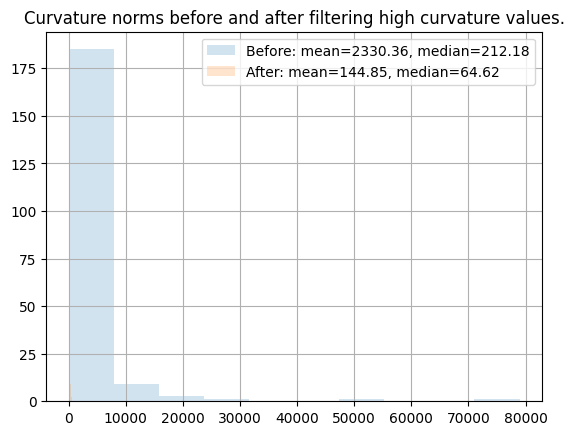

In [12]:
CURVATURE_PROFILES_DIR = os.path.join(os.getcwd(), "results", "curvature_profiles")

curv_norm_learned_profile = pd.read_csv(
    os.path.join(
        CURVATURE_PROFILES_DIR, config.results_prefix + "_curv_norm_learned_profile.csv"
    )
)

median = curv_norm_learned_profile["curv_norm_learned"].median()
filtered = curv_norm_learned_profile[
    curv_norm_learned_profile["curv_norm_learned"] < 3 * median
]

fig, ax = plt.subplots(1, 1)

mean = curv_norm_learned_profile["curv_norm_learned"].mean()
median = curv_norm_learned_profile["curv_norm_learned"].median()
label = f"Before: mean={mean:.2f}, median={median:.2f}"
curv_norm_learned_profile["curv_norm_learned"].hist(
    ax=ax, color="C0", label=label, alpha=0.2
)

mean = filtered["curv_norm_learned"].mean()
median = filtered["curv_norm_learned"].median()
label = f"After: mean={mean:.2f}, median={median:.2f}"
filtered["curv_norm_learned"].hist(ax=ax, color="C1", label=label, alpha=0.2)
ax.legend()
ax.set_title("Curvature norms before and after filtering high curvature values.");

In [13]:
z_grid = curv_norm_learned_profile["z_grid"]

# Study curvature and rat's velocity

### Plot neural manifolds (color=velocity)

The neural manifold shows the **inverse** of the curvature, i.e. is a visualization of the shape of the actual manifold.

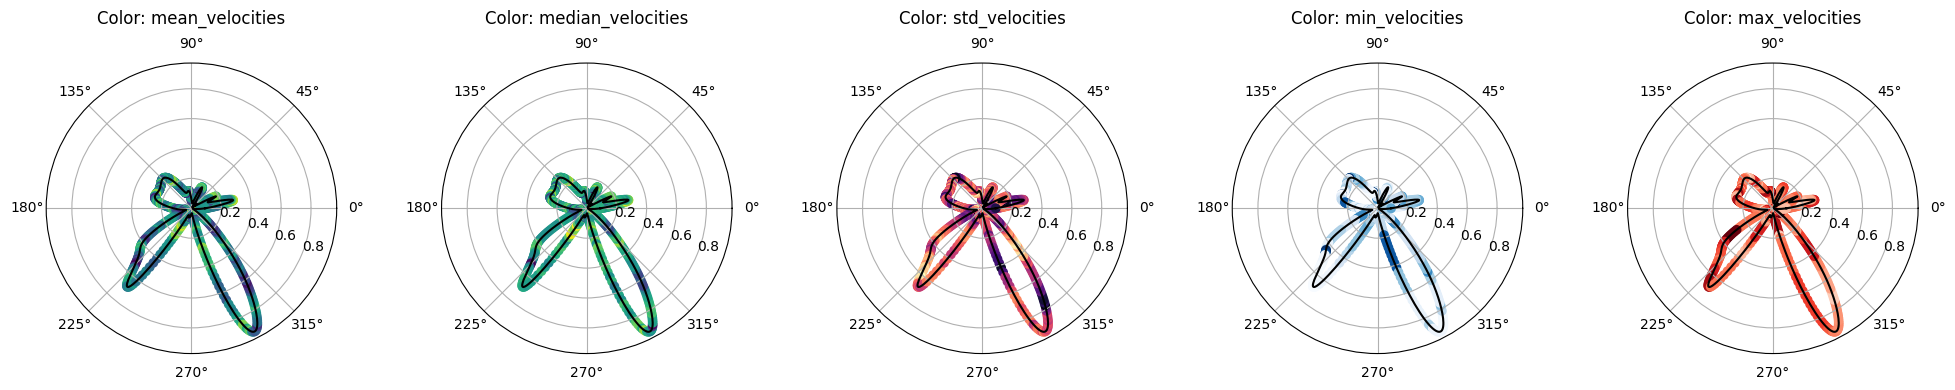

In [18]:
# Without removing high curvature values
viz.plot_neural_manifold_learned(curv_norm_learned_profile, config, labels);

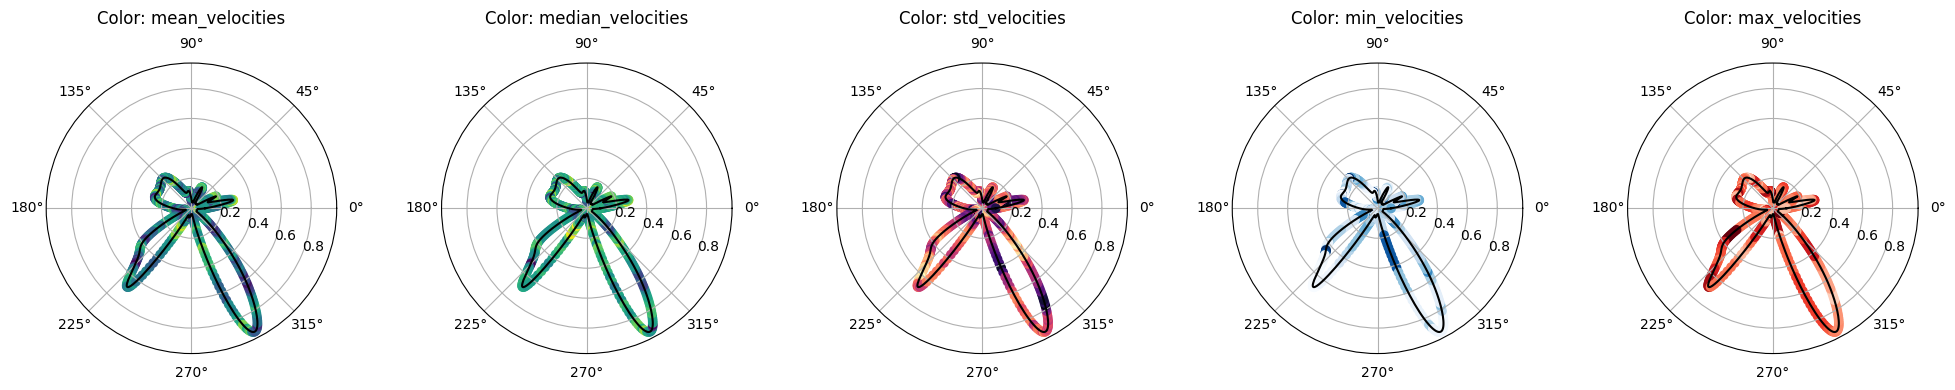

In [19]:
# With filter: i.e., removing high curvature values
viz.plot_neural_manifold_learned(filtered, config, labels);

We cannot really see any difference between the filtered and non-filtered, because high curvatures mean neural manifold's radius close to 0, and everything is collapsed at 0.

### Correlation between curvature and velocity

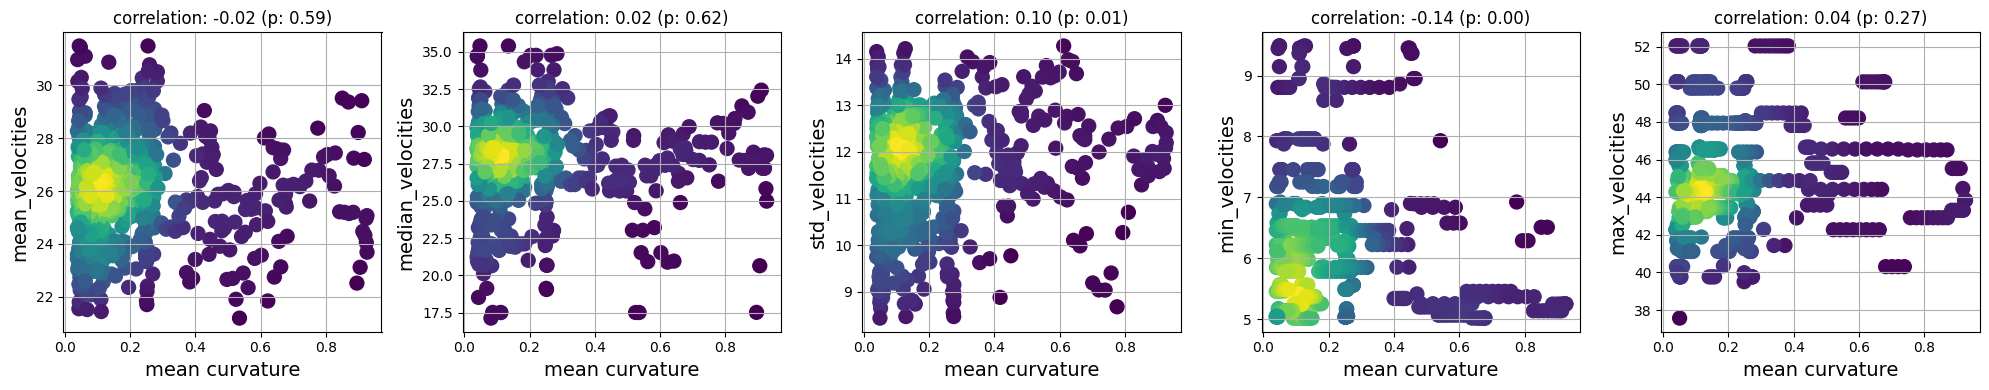

In [20]:
from scipy.stats import gaussian_kde, pearsonr

stats = [
    "mean_velocities",
    "median_velocities",
    "std_velocities",
    "min_velocities",
    "max_velocities",
]
cmaps = ["viridis", "viridis", "magma", "Blues", "Reds"]

fig, axes = plt.subplots(nrows=1, ncols=len(stats), figsize=(20, 4))
for i_stat, stat_velocities in enumerate(stats):
    ax = axes[i_stat]
    x = 1 / filtered["curv_norm_learned"]
    y = filtered[stat_velocities]
    # Calculate the point density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    ax.set_xlabel("mean curvature", fontsize=14)
    ax.scatter(x, y, c=z, s=100)
    ax.grid(True)
    ax.set_ylabel(stat_velocities, fontsize=14)
    pears = pearsonr(x, y)
    # print(pears.statistic)
    ax.set_title(f"correlation: {pears.statistic:.2f} (p: {pears.pvalue:.2f})")
fig.tight_layout()

# Study curvature and neural activations

### Plot recorded and recontructed activations

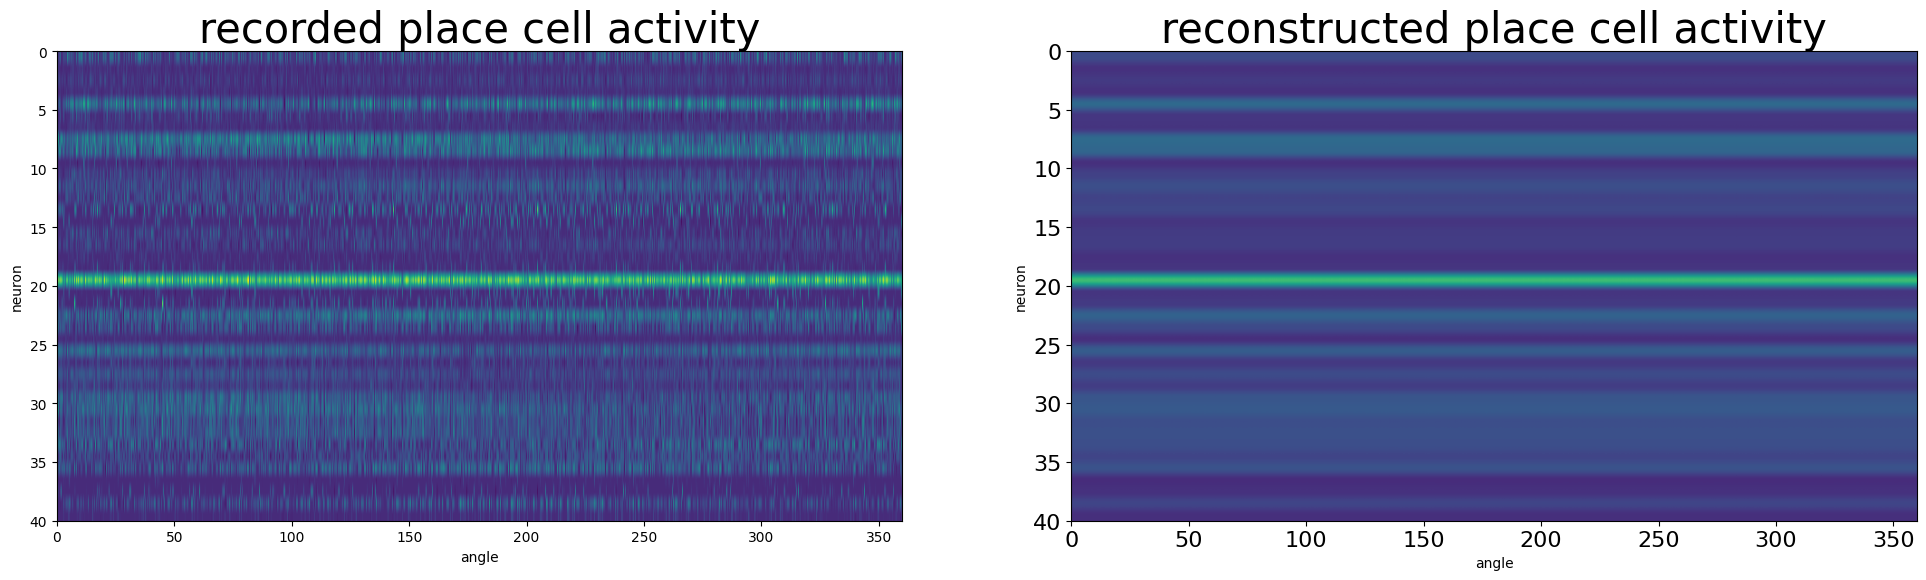

In [203]:
trained_models_dir = os.path.join(os.getcwd() + "/results/trained_models")

model_path = os.path.join(trained_models_dir, f"{config.results_prefix}_model.pt")
model = torch.load(model_path)

viz.plot_recon_per_positional_angle(model, dataset_torch, labels, config);

### Plot neural manifolds (color=activation)

Get dataset and reconstructed dataset sorted by angles.

In [204]:
thetas = np.array(labels["angles"])
sort = np.argsort(thetas)
dataset = dataset_torch.cpu().detach().numpy()
sorted_dataset = dataset[sort, :]

_, rec, _ = model(dataset_torch)
rec = rec.cpu().detach().numpy()
sorted_rec = rec[sort, :]

In [217]:
np.max(sorted_dataset)

1.0

In [219]:
def plot_neural_manifold_learned_activations(
    show_recon=True, single_norm=True, nrows=2
):
    """Plot neural manifold colored by activations of neurons.

    Parameters
    ----------
    show_recon : bool
        If True, color with true activation.
        If False, color with reconstructed activation.
    single_norm : bool
        Normalization type for the color map.
        If True, use the maximum activation for each neuron.
        If False, use the maximum activation across neurons.
    """
    _, n_neurons = dataset_torch.shape

    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=n_neurons // nrows,
        figsize=(20, 4 * nrows),
        subplot_kw={"projection": "polar"},
    )
    color_norm = mpl.colors.Normalize(0.0, np.max(sorted_dataset))
    activations = sorted_dataset
    if show_recon:
        activations = sorted_rec

    for i in range(n_neurons):
        if single_norm:
            color_norm = mpl.colors.Normalize(0.0, np.max(sorted_dataset[:, i]))
        ax = axes[i % nrows, i // nrows]
        ax.scatter(
            curv_norm_learned_profile["z_grid"][
                1::15
            ],  ## taking a fithteenth of the entries: change to have more points on the manifold
            1 / curv_norm_learned_profile["curv_norm_learned"][1::15],
            c=activations[1::15, i],
            cmap="viridis",
            norm=color_norm,
        )
        ax.set_rticks([1])  # Less radial ticks
        ax.set_rlabel_position(0)  # Move radial labels away from plotted line
        ax.grid(True)
        ax.set_title("Color: neuron" + str(i), va="bottom")
    fig.tight_layout()
    # fig.savefig(
    #     f"notebooks/figures/run_{run_id}_show_recon_{show_recon}_single_norm_{single_norm}_neural_manifold.svg"
    # )

ValueError: 'c' argument has 63 elements, which is inconsistent with 'x' and 'y' with size 14.

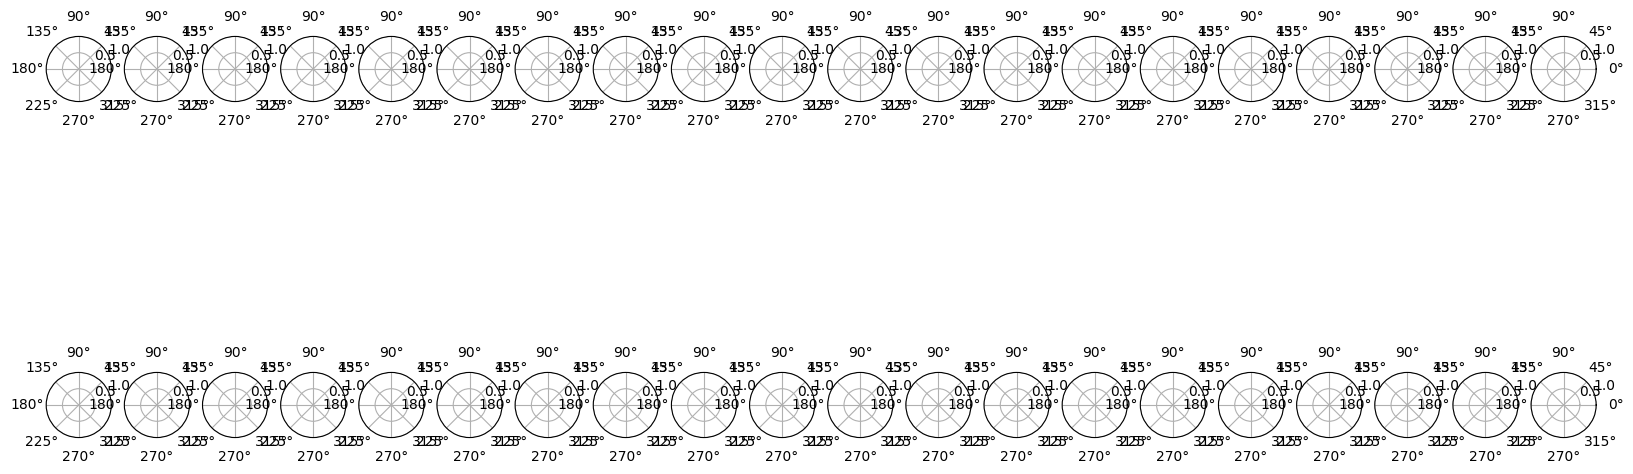

In [220]:
plot_neural_manifold_learned_activations(show_recon=True, single_norm=False, nrows=2)

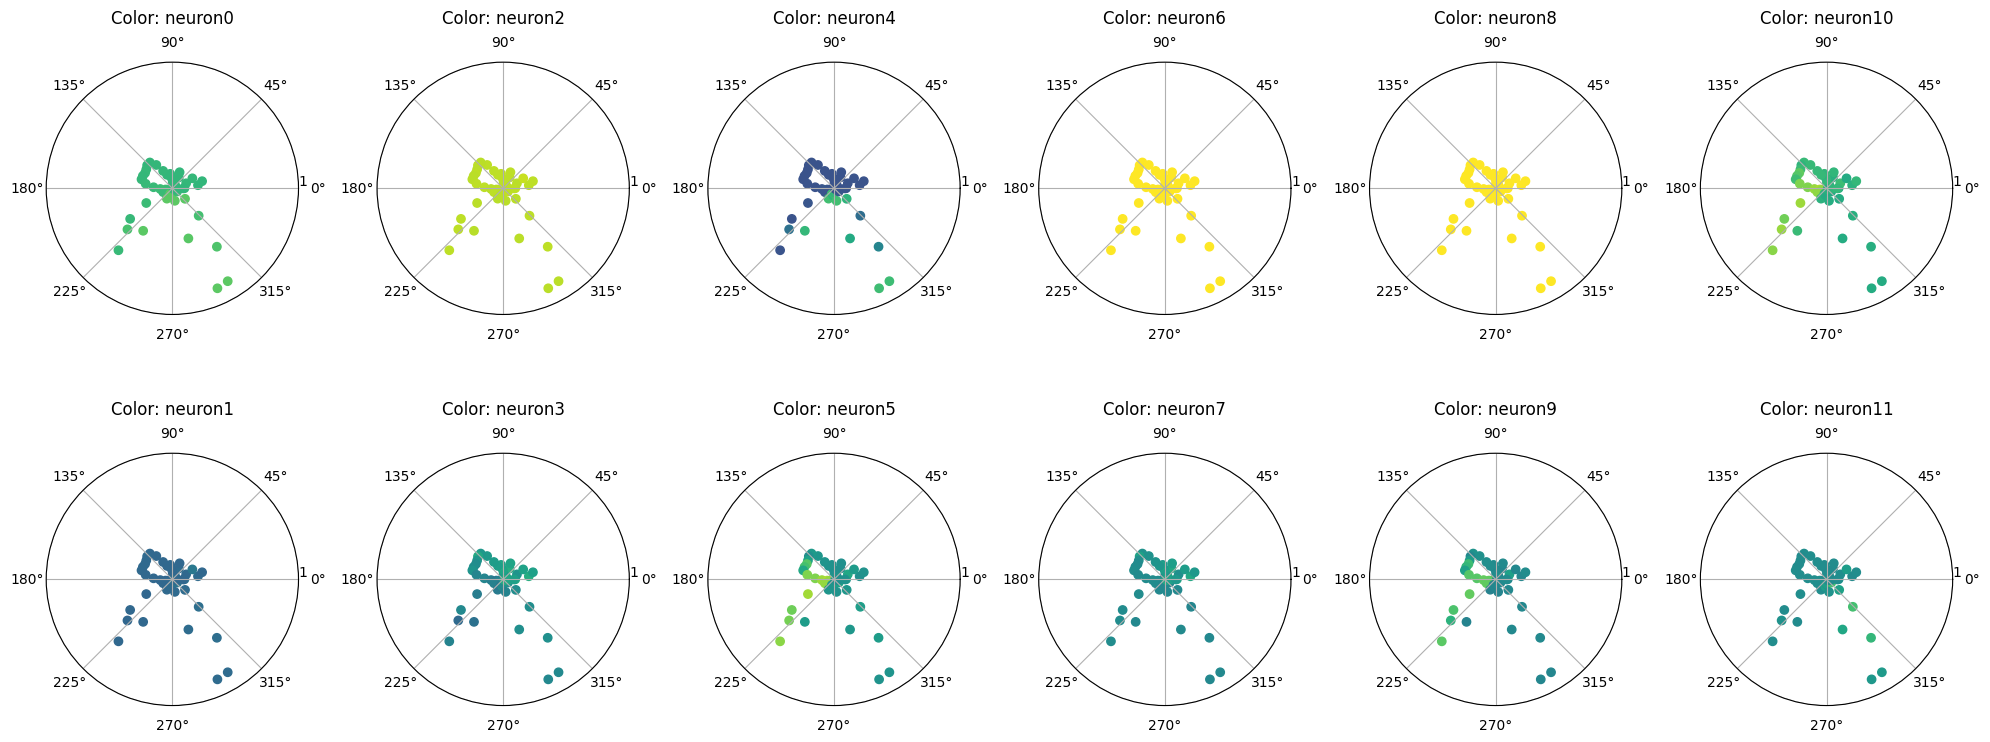

In [28]:
plot_neural_manifold_learned_activations(show_recon=True, single_norm=True, nrows=2)

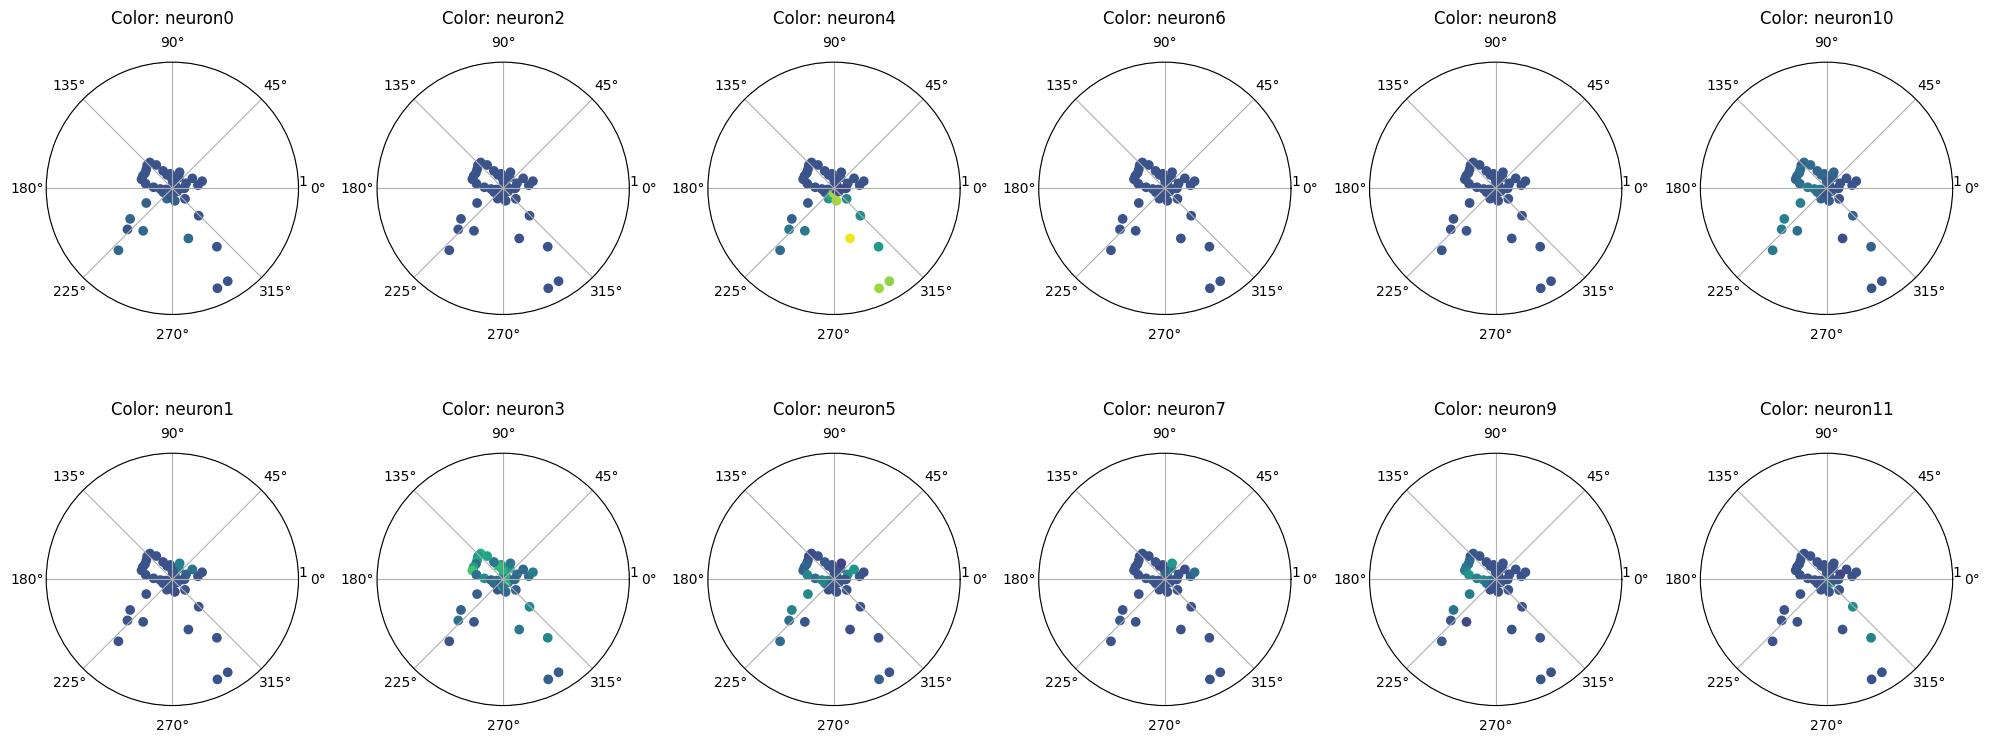

In [29]:
plot_neural_manifold_learned_activations(show_recon=False, single_norm=False, nrows=2)

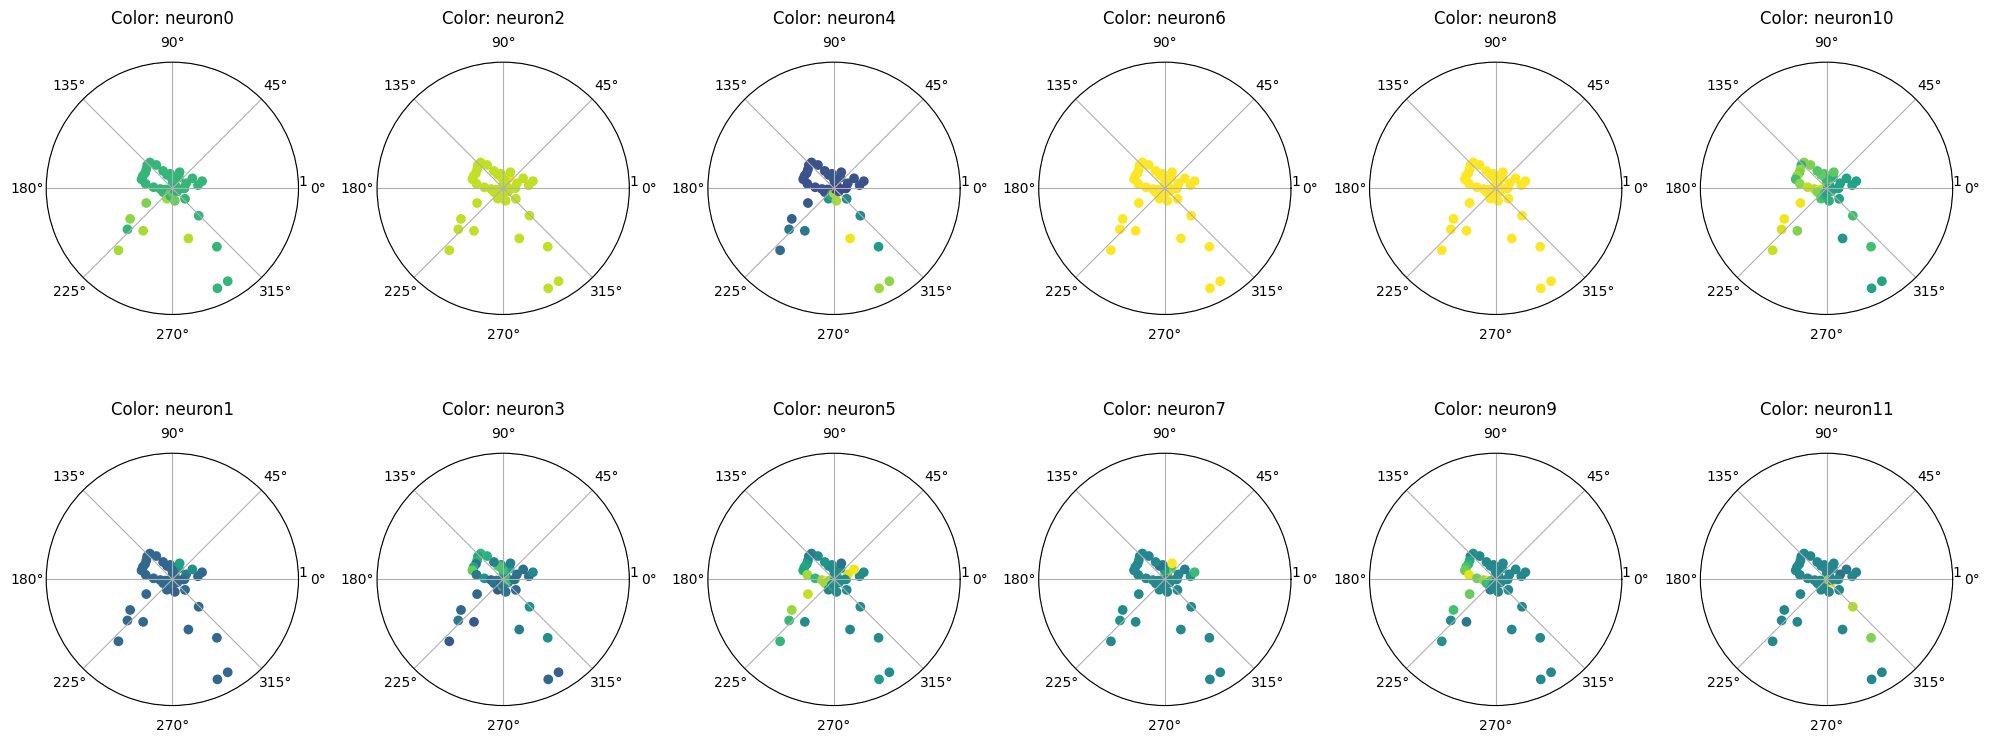

In [30]:
plot_neural_manifold_learned_activations(show_recon=False, single_norm=True, nrows=2)

# Towards Parameterization invariance

The neural manifold shows the **inverse** of the curvature, i.e. is a visualization of the shape of the actual manifold.

We use the geodesic distance on S1 to plot the neural manifold, so that the visualization is reparameterization invariant.

In [233]:
curv_norm_learned_profile

,Unnamed: 0,z_grid,geodesic_dist,curv_norm_learned,mean_velocities,median_velocities,std_velocities,min_velocities,max_velocities
0,0,0.000000,0.0,98.054760,16.469547,14.466303,8.215152,5.012452,38.338179
1,1,0.031574,0.0,170.167659,21.146919,21.990868,9.298757,5.012452,40.816980
2,2,0.063148,0.0,333.348696,21.225460,22.207197,9.782196,5.651123,40.816980
3,3,0.094721,0.0,785.776325,18.324566,19.535285,9.370410,5.156031,34.358506
4,4,0.126295,0.0,2535.491027,18.738564,14.344672,11.933653,5.156031,42.821964
...,...,...,...,...,...,...,...,...,...
195,195,6.156890,0.0,21.232985,20.846175,15.728060,13.952341,5.044550,44.781166
196,196,6.188464,0.0,28.975329,19.157356,15.293377,10.865735,5.044550,44.781166
197,197,6.220038,0.0,41.186692,15.787696,13.674101,8.321714,5.429119,33.755700
198,198,6.251612,0.0,61.549151,15.626891,16.133269,8.241148,5.429119,33.755700


We will add a column to the dataframe, that records the geodesic distance from a reference z0, chosen to be the first element of the grid.

We first load the model of that run to get the learned immersion.

In [33]:
import time

import geomstats.backend as gs
from geomstats.geometry.pullback_metric import PullbackMetric

import evaluate

learned_immersion = evaluate.get_learned_immersion(model, config)

neural_metric = PullbackMetric(
    dim=1, embedding_dim=config.data_dim, immersion=learned_immersion
)

## Decide for optimal computations of geodesic distance

Commpare which option is faster.

1. Everything on cuda --> bugs in geomstats.

In [ ]:
z_grid = torch.tensor(curv_norm_learned_profile["z_grid"].values)
z_grid = z_grid.to("cuda:0")
z0 = torch.unsqueeze(z_grid[0], dim=0)
print(next(model.parameters()).device)
print(z_grid.device)
print(z0.device)

geodesic_dist = gs.zeros(len(z_grid))
print(f"z_grid.shape = {z_grid.shape}")
for i_z, z in enumerate(z_grid[:2]):
    print(f"Grid point id: {i_z}")
    if i_z > 0:
        z = torch.unsqueeze(z, dim=0)
        print(z.device)
        start = time.time()
        dist = neural_metric.dist(z0, z)
        duration = time.time() - start
        print(f"Time: {duration:.3f}")
        print(f"Device for dist: {dist.device}")
        geodesic_dist[i_z] = dist

2. Everything on cpu  --> bugs in geomstats.

In [ ]:
model.to("cpu")
z_grid = torch.tensor(curv_norm_learned_profile["z_grid"].values)
z0 = torch.unsqueeze(z_grid[0], dim=0)
print(next(model.parameters()).device)
print(z_grid.device)
print(z0.device)

geodesic_dist = gs.zeros(len(z_grid))
print(f"z_grid.shape = {z_grid.shape}")
for i_z, z in enumerate(z_grid[:2]):
    print(f"Grid point id: {i_z}")
    if i_z > 0:
        z = torch.unsqueeze(z, dim=0)
        print(z.device)
        start = time.time()
        dist = neural_metric.dist(z0, z)
        duration = time.time() - start
        print(f"Time: {duration:.3f}")
        print(f"Device for dist: {dist.device}")
        geodesic_dist[i_z] = dist

3. Some gpu and some cpu.

We use the parameter n_steps to regulate how precise the computation of the distance is.


TODO: compute the distance between neighboring points so that the exp / log integration are more stable.

In [34]:
model.to("cuda:0")
z_grid = torch.tensor(curv_norm_learned_profile["z_grid"].values)
z0 = torch.unsqueeze(z_grid[0], dim=0)
print(f"Model:{next(model.parameters()).device}")
print(f"Zgrid: {z_grid.device}")
print(f"Z0: {z0.device}\n")

geodesic_dist = gs.zeros(len(z_grid))
print(f"Starting for loop: z_grid.shape = {z_grid.shape}")
for i_z, z in enumerate(z_grid[:3]):
    print(f"Grid point id: {i_z}")
    if i_z > 0:
        z = torch.unsqueeze(z, dim=0)
        z_previous = torch.unsqueeze(z_grid[i_z - 1], dim=0)
        print(f"Z: {z.device}")
        print(f"Zprevious: {z.device}")
        start = time.time()
        # Tricks to speed up this computation:
        # 1. Compute with less number of steps for the integration of the geodesic eqn
        # 2. Compute distance between neighboring z's
        dist = neural_metric.dist(z_previous, z, n_steps=10)
        duration = time.time() - start
        print(f"Time: {duration:.3f}")
        print(f"Dist: {dist.device}")
        geodesic_dist[i_z] = dist

Model:cuda:0
Zgrid: cpu
Z0: cpu

Starting for loop: z_grid.shape = torch.Size([828])
Grid point id: 0
Grid point id: 1
Z: cpu
Zprevious: cpu
Time: 5.133
Dist: cpu
Grid point id: 2
Z: cpu
Zprevious: cpu
Time: 5.149
Dist: cpu


## Parallel computations of geodesic distances

Let's parallelize this.

In [ ]:
import copy
import logging

from joblib import Parallel, delayed

model.to("cuda:0")
z_grid = torch.tensor(curv_norm_learned_profile["z_grid"].values)
z0 = torch.unsqueeze(z_grid[0], dim=0)


# TODO (use logging to actually print and know which iterations we are on)
def _geodesic_dist(i_z, z, grid_interval):
    if i_z == 0:
        return (0, torch.tensor(0.0))
    # Parallelize on gpus: is that line really helping,
    # i.e. is the copy taking less time than the computation? if not, don't bother
    # also: does it change anything since neural metric has already been computed and uses the old version of model?
    model_copy = copy.deepcopy(model).to(f"cuda:{i_z % 9}")
    z = torch.unsqueeze(z, dim=0)
    z_previous = torch.unsqueeze(z_grid[i_z - grid_interval], dim=0)
    start = time.time()
    # Tricks to speed up this computation:
    # 1. Compute with less number of steps for the integration of the geodesic eqn
    # 2. Compute distance between neighboring z's
    dist = neural_metric.dist(z_previous, z, n_steps=7)
    duration = time.time() - start
    logging.info(f"Time (it: {i_z}): {duration:.3f}")
    return (i_z, dist)


# To try this code , use z_grid[:5] to run on smaller batch
# Currently, the z_grid is too big (~800) --> go to 100
# Note: each distance computation takes ~5s.
grid_interval = 1
res = Parallel(n_jobs=-1)(
    delayed(_geodesic_dist)(i_z, z, grid_interval)
    for i_z, z in enumerate(z_grid)
    if i_z % grid_interval == 0
)

In [16]:
type(curv_norm_learned_profile["curv_norm_learned"])

pandas.core.series.Series

In [ ]:
geodesic_dists = torch.zeros(len(res))
curv_norms = torch.zeros(len(res))
for i_z, dist in res:
    geodesic_dists[i_z] = dist
    curv_norms[i_z] = curv_norm_learned_profile["curv_norm_learned"].values[i_z]

print(geodesic_dists[:10])
print(curv_norms[:10])
print(1 / curv_norms[:10])

print(len(geodesic_dists))

In [ ]:
cumul_geodesic_dists = torch.cumsum(geodesic_dists, dim=0)
cumul_geodesic_dists[:10]
print(cumul_geodesic_dists.max())

## Plot invariant neural manifold (colored)

In [ ]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

stats = [
    "mean_velocities",
    "median_velocities",
    "std_velocities",
    "min_velocities",
    "max_velocities",
]
cmaps = ["viridis", "viridis", "magma", "Blues", "Reds"]

fig, axes = plt.subplots(
    nrows=len(stats), ncols=1, figsize=(20, 20), subplot_kw={"projection": "polar"}
)

i_zs = [i_z for i_z, _ in res]
subgrid_profile = curv_norm_learned_profile  # .take(i_zs)
print(len(subgrid_profile))

for i_stat, stat_velocities in enumerate(stats):
    ax = axes[i_stat]
    ax.scatter(
        cumul_geodesic_dists,
        1 / curv_norms,
        c=subgrid_profile[stat_velocities],
        cmap=cmaps[i_stat],
    )
    ax.plot(
        cumul_geodesic_dists,
        1 / curv_norms,
        c="black",
    )
    # ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
    ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
    ax.grid(True)
    ax.set_title("Color: " + stat_velocities, va="bottom")
fig.tight_layout()

## Plot invariant neural manifold (uncolored)

In [ ]:
closed_geodesic_dists = torch.concat(
    [cumul_geodesic_dists, torch.tensor([cumul_geodesic_dists[0]])]
)
closed_curv_norms = torch.concat([curv_norms, torch.tensor([curv_norms[0]])])

In [ ]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

stats = [
    "mean_velocities",
    "median_velocities",
    "std_velocities",
    "min_velocities",
    "max_velocities",
]
cmaps = ["viridis", "viridis", "magma", "Blues", "Reds"]

fig, ax = plt.subplots(
    nrows=1, ncols=1, figsize=(6, 6), subplot_kw={"projection": "polar"}
)

i_zs = [i_z for i_z, _ in res]
subgrid_profile = curv_norm_learned_profile.take(i_zs)

ax.plot(closed_geodesic_dists, 1 / closed_curv_norms, c="black")
# ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)
ax.set_title("Color: " + stat_velocities, va="bottom")
fig.tight_layout()
# import os
# print(os.getcwd())
fig.savefig(f"notebooks/figures/run_{run_id}_invariant_manifold.svg")

Note: this looping is weird, and the geodesic distances go well over 14, i.e. over 3.14*2 which is 2 pi. There must be an error.